In [1]:
import os
from glob import glob

import tqdm
import IPython
import torch
import torchaudio
import matplotlib.pyplot as plt
import scipy.stats
import wandb

from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from vseq.data import BaseDataset
from vseq.data.batchers import AudioBatcher, ListBatcher
from vseq.data.datapaths import DATASETS, TIMIT
from vseq.evaluation import Tracker
from vseq.data.loaders import AudioLoader, TIMITAlignmentLoader, TIMITSpeakerLoader
from vseq.data.samplers.batch_samplers import LengthEvalSampler
from vseq.data.transforms import MuLawEncode, MuLawDecode
from vseq.models.clockwork_vae import CWVAEAudioTasNet
from vseq.settings import CHECKPOINT_DIR
from vseq.utils.device import *

In [2]:
CHECKPOINT_DIR

'/scratch/jdha/vseq/wandb'

# Setup

In [3]:
# Make plotting directory
os.makedirs("./figures/cwvae_evaluation", exist_ok=True)

In [4]:
# If CPU only, force GPU
if "CUDA_VISIBLE_DEVICES" in os.environ and os.environ["CUDA_VISIBLE_DEVICES"] == "":
    del os.environ["CUDA_VISIBLE_DEVICES"]

In [5]:
torch.autograd.set_grad_enabled(False)

1xrnjn5y | Big V100 model, 2 layers

In [6]:
run_id = "2k4f9q73"  # trim-puddle, 3 layers, 8bit mu-law
run_id = "e4812rhg"  # fresh-galaxy, 1 layer, 16bit mu-law
run_id = "1xrnjn5y"  # sweet-sunset, 2 layers, 16bit mu-law
dataset = DATASETS[TIMIT]

In [7]:
def find_run_path(run_id, checkpoint_dir=CHECKPOINT_DIR):
    run_dirs = os.listdir(checkpoint_dir)
    run_dir = [run_dir for run_dir in run_dirs if run_id in run_dir]

    if len(run_dir) > 1:
        raise IOError(f"More than one run found with ID {run_id}: {run_dir}")
    elif len(run_dir) == 0:
        raise IOError(f"No runs found with ID {run_id}")
    return os.path.join(checkpoint_dir, run_dir[0])


def download_run(run_id, project=None, entity=None, checkpoint_dir=CHECKPOINT_DIR, replace: bool = False, verbose=True, exclude: Union[str, List[str]] = ""):
    exclude = [exclude] if isinstance(exclude, str) else exclude
    
    run_files_path = os.path.join(checkpoint_dir, run_id, "files")

    if entity is None and project is None:
        remote_path = f"{run_id}"
    elif entity is None:
        remote_path = f"{project}/{run_id}"
    else:
        remote_path = f"{entity}/{project}/{run_id}"

    api = wandb.Api()
    run = api.run(remote_path)
    all_files = run.files()

    excluded_files = [f for f in all_files if any([exc in f.name for exc in exclude])]
    files = list(set(all_files) - set(excluded_files))
    if verbose:
        print(f"Excluded {len(excluded_files)} files from the download of run with id {run_id}")

    iterator = tqdm.tqdm(files) if verbose else files
    for f in iterator:
        f.download(root=run_files_path, replace=replace)
    return run_files_path


def get_run(run_id, project=None, entity=None, exclude=""):
    """Find the run on disk or create it and download all remotely stored files from wandb"""
    try:
        run_path = find_run_path(run_id)
        run_files_path = os.path.join(run_path, "files")
    except IOError:
        run_files_path = download_run(run_id, project, entity, exclude=exclude)
    return run_files_path

In [8]:
def logistic_mixture_pdf(x, means, log_scales, unnorm_weights):
    pdf = np.zeros_like(x)

    weights = unnorm_weights.softmax(-1).cpu().numpy()
    means = means.cpu().numpy()
    variances = log_scales.exp().cpu().numpy()

    n_mix = variances.shape[0]

    for i in range(n_mix):
        pdf += scipy.stats.logistic.pdf(x, loc=means[i], scale=variances[i]) * weights[i]
        
    return pdf

In [9]:
def plot_logistic_mixture(means, log_scales, unnorm_weights, x_min=-1, x_max=1, n_vals=100, ax=None):
    l = np.linspace(x_min, x_max, n_vals)
    pdf = logistic_mixture_pdf(l, means, log_scales, unnorm_weights)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    ax.plot(l, pdf)
    return fig, ax

# Load model

In [10]:
run_files_path = get_run(run_id, "cwvae", "vseq", exclude="media/")
run_files_path

'/scratch/jdha/vseq/wandb/1xrnjn5y/files'

In [11]:
!gpustat
device = get_free_gpus(1)
model = CWVAEAudioTasNet.load(run_files_path, device=device)

phoebe                         Wed Sep 15 17:50:31 2021  465.24.02
[0] NVIDIA GeForce GTX 1080 Ti | 19'C,   0 % |     1 / 11178 MB |
[1] NVIDIA GeForce GTX 1080 Ti | 55'C,  11 % | 10885 / 11178 MB | s183983(10881M)
[2] NVIDIA GeForce GTX 1080 Ti | 61'C,   0 % |  9295 / 11178 MB | s183983(9291M)
[3] NVIDIA GeForce GTX 1080 Ti | 60'C,  55 % | 10579 / 11178 MB | s183983(10575M)
[4] NVIDIA GeForce GTX 1080 Ti | 54'C,   0 % |  9669 / 11178 MB | s183983(9665M)
[5] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[6] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[7] NVIDIA GeForce GTX 1080 Ti | 58'C,  29 % |   657 / 11178 MB | andba(653M)
Selected global device(s): [0]


In [12]:
# model.summary(input_size=(4, model.overall_stride), x_sl=torch.tensor([model.overall_stride]), device="cpu");

In [13]:
audio_loader = AudioLoader("wav", cache=False)
audio_batcher = AudioBatcher(padding_module=model.overall_stride)
transform_enc = MuLawEncode(bits=16)
transform_dec = MuLawDecode(bits=16)

In [14]:
modalities = [
    (audio_loader, transform_enc, audio_batcher),
    (TIMITAlignmentLoader("PHN"), None, ListBatcher()),
    (TIMITAlignmentLoader("WRD"), None, ListBatcher()),
    (TIMITSpeakerLoader(), None, ListBatcher()),
]

train_dataset = BaseDataset(
    source=dataset.train,
    modalities=modalities,
)
valid_dataset = BaseDataset(
    source=dataset.test,
    modalities=modalities,
)

In [15]:
(a, w, p, s), metadata = valid_dataset[0]
# a, w, p, s, metadata

# Latent space evaluation

In [16]:
import itertools

from collections import Counter

from vseq.data.loaders import TIMIT_PHONE2INT, TIMIT_INT2PHONE

## Visual

### Different phonemes, same speaker

In [17]:
(a, p, w, s), metadata = valid_dataset[0]
s

TIMITSpeakerMetadata(speaker_id='AKS0', sex='F', dialect='New England', use='TST', recorded=datetime.datetime(1986, 4, 1, 0, 0), birthday=datetime.datetime(2057, 12, 5, 0, 0), height='5\'04"', race='WHT', education='PHD', comments='')

In [18]:
speaker_id = "AKS0"
speaker_id = "BJK0"

In [19]:
speaker_data = [(i, ((a, p, w, s), metadata)) for i, ((a, p, w, s), metadata) in enumerate(valid_dataset) if s.speaker_id == speaker_id]
print(len(speaker_data))

10


In [20]:
speaker_audio = [a for (i, ((a, p, w, s), metadata)) in speaker_data]
speaker_phone = [p for (i, ((a, p, w, s), metadata)) in speaker_data]

In [21]:
speaker_phone_token = [p[2] for (i, ((a, p, w, s), metadata)) in speaker_data]
speaker_phone_start = [torch.tensor(p[0]) for (i, ((a, p, w, s), metadata)) in speaker_data]
speaker_phone_stop = [torch.tensor(p[1]) for (i, ((a, p, w, s), metadata)) in speaker_data]

In [22]:
# Count most common phonemes
all_speaker_phones = [p for phs in speaker_phone_token for p in phs ]
cntr = Counter(all_speaker_phones)
print(len(all_speaker_phones), "\n", cntr.most_common())

380 
 [('h#', 20), ('eh', 16), ('iy', 15), ('s', 15), ('n', 14), ('r', 13), ('kcl', 12), ('t', 12), ('er', 12), ('tcl', 11), ('q', 11), ('ix', 10), ('l', 10), ('m', 10), ('ae', 9), ('k', 9), ('ao', 9), ('ih', 9), ('ax', 9), ('v', 9), ('gcl', 8), ('g', 8), ('dx', 8), ('ah', 8), ('dcl', 7), ('axr', 7), ('d', 7), ('w', 7), ('epi', 7), ('pcl', 7), ('ay', 6), ('dh', 6), ('z', 6), ('pau', 5), ('sh', 4), ('p', 4), ('aa', 3), ('y', 3), ('ow', 3), ('oy', 3), ('b', 3), ('nx', 3), ('hv', 2), ('jh', 2), ('f', 2), ('hh', 2), ('aw', 2), ('el', 2), ('bcl', 2), ('th', 2), ('uw', 1), ('ax-h', 1), ('ng', 1), ('ux', 1), ('zh', 1), ('ey', 1)]


In [23]:
# Convert to time scale of latent representations
speaker_phone_start_latent = [[torch.floor(p / tf).to(int) for p in speaker_phone_start] for tf in model.time_factors]
speaker_phone_stop_latent = [[torch.ceil(p / tf).to(int) for p in speaker_phone_stop] for tf in model.time_factors]

In [24]:
speaker_phone_start_latent[0][0][-1], speaker_phone_start_latent[1][0][-1]

(tensor(836), tensor(104))

In [25]:
# Align labels with latent representations
labels_latent = [None] * n_latents
labels_length = [None] * n_latents
for i_latent in range(n_latents):
    labels_latent[i_latent] = []
    labels_length[i_latent] = []

    for i_example in range(n_examples):
        length = speaker_phone_stop_latent[i_latent][i_example].shape[-1]

        boundaries = torch.cat([torch.zeros(1), speaker_phone_stop_latent[i_latent][i_example]])

        labels = []
        for i_element in range(length):
            start = int(boundaries[i_element])
            stop = int(boundaries[i_element+1])

            labs = [TIMIT_PHONE2INT[speaker_phone_token[i_example][i_element]]] * (stop - start)
            labels.extend(labs)

        labels_length[i_latent].append(len(labels))
        labels_latent[i_latent].append(torch.tensor(labels))

NameError: name 'n_latents' is not defined

In [ ]:
# Embed in latent space via model
outputs = []
for x in speaker_audio:
    x, x_sl = audio_batcher([x])
    x = x.to(device)
    loss, metrics, output = model(x, x_sl)
    outputs.append(output)

In [ ]:
outputs[0].latents[0].shape, outputs[0].latents[1].shape

In [ ]:
n_latents = len(outputs[0].latents)
n_examples = len(outputs)

In [ ]:
# latents[i_latent][i_example] squeeze batch dim
latents = [[outputs[b].latents[i_latent].squeeze(0) for b in range(n_examples)] for i_latent in range(n_latents)]

In [ ]:
# Remove padding from latent representations according to phoneme labels
print(latents[0][1].shape)
latents = [[latents[i_latent][i_example][:labels_length[i_latent][i_example]] for i_example in range(n_examples)] for i_latent in range(n_latents)]
print(latents[0][1].shape)

In [ ]:
# all representations as one timeseries per latent
latents_cat = [torch.cat(latents[i_latent], dim=0) for i_latent in range(n_latents)]
labels_latent_cat = [torch.cat(labels_latent[i_latent], dim=0) for i_latent in range(n_latents)]
latents_cat[0].shape, labels_latent_cat[0].shape

In [ ]:
n_components = 7
combinations = list(itertools.combinations(range(n_components), 2))
n_combinations = len(combinations)
print(n_combinations, np.sqrt(n_combinations), int(np.ceil(np.sqrt(n_combinations))), combinations)

In [ ]:
h = 3
w = 7

In [ ]:
pca = PCA(n_components=n_components, whiten=True)

latents_pca = [pca.fit_transform(latents_cat[i_latent].cpu().numpy()) for i_latent in range(n_latents)]

In [ ]:
isomap = Isomap(n_components=n_components, n_neighbors=5)

latents_isomap = [isomap.fit_transform(latents_cat[i_latent].cpu().numpy()) for i_latent in range(n_latents)]

`[('h#', 20), ('n', 20), ('ix', 19), ('s', 18), ('iy', 16), ('kcl', 15), ('r', 14), ('k', 14), ('l', 13), ('d', 12), ('tcl', 11), ('ax', 11), ('bcl', 11), ('dcl', 10), ('aa', 10), ('b', 10), ('f', 10), ('er', 9), ('ae', 8), ('sh', 7), ('ih', 7), ('w', 7), ('ao', 6), ('axr', 6), ('t', 6), ('dh', 6), ('z', 6), ('p', 6), ('y', 5), ('gcl', 5), ('g', 5), ('epi', 5), ('ow', 5), ('pcl', 5), ('q', 4), ('m', 4), ('v', 4), ('uw', 3), ('dx', 3), ('ay', 3), ('ux', 3), ('el', 3), ('aw', 3), ('ey', 3), ('hv', 2), ('eh', 2), ('hh', 2), ('ah', 2), ('en', 2), ('ch', 2), ('uh', 2), ('ng', 1), ('oy', 1), ('th', 1)]`

In [ ]:
SELECTED_PHONEMES = ["iy", "n"]
SELECTED_PHONEMES = ["iy", "jh"]
SELECTED_PHONEMES = ["hh", "ng"]
SELECTED_PHONEMES = ["s", "y"]
# SELECTED_PHONEMES = ["iy", "ih", "eh", "ey", "ae", "aa", "aw", "ay", "ah", "ao", "oy", "ow", "uh", "uw", "ux", "er", "ax", "ix", "axr", "ax-h"]

phonemes_int = [TIMIT_PHONE2INT[p] for p in SELECTED_PHONEMES]

phonemes2idx = [dict([(p, labels_latent_cat[i_latent] == pi) for p, pi in zip(SELECTED_PHONEMES, phonemes_int)]) for i_latent in range(n_latents)]

idx_or = [sum([idx for idx in phonemes2idx[i_latent].values()]).to(bool) for i_latent in range(n_latents)]  # select all classes

In [ ]:
i_latent = 0

fig, axes = plt.subplots(h, w, figsize=(16, 9))
fig.tight_layout()

axes = [a for ax in axes for a in ax]
for c in range(n_combinations):
    for phone, idx in phonemes2idx[i_latent].items():
        i, j = combinations[c]
        axes[c].scatter(latents_pca[i_latent][idx, i], latents_pca[i_latent][idx, j], alpha=0.5, label=phone)
        # axes[c].scatter(latents_pca[i_latent][:, i], latents_pca[i_latent][:, j], alpha=0.5, label=phone)
        axes[c].set_xlabel(i)
        axes[c].set_ylabel(j)
plt.legend()

In [ ]:
i_latent = 0

fig, axes = plt.subplots(h, w, figsize=(16, 9))
fig.tight_layout()

axes = [a for ax in axes for a in ax]
for c in range(n_combinations):
    for phone, idx in phonemes2idx[i_latent].items():
        i, j = combinations[c]
        axes[c].scatter(latents_isomap[i_latent][idx, i], latents_isomap[i_latent][idx, j], alpha=0.5, label=phone)
        # axes[c].scatter(latents_pca[i_latent][:, i], latents_pca[i_latent][:, j], alpha=0.5, label=phone)
        axes[c].set_xlabel(i)
        axes[c].set_ylabel(j)
plt.legend()

In [ ]:
# Probe with SVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
clf = SVC(kernel="linear", C=0.025)

idx_or = sum([idx for idx in phonemes2idx[i_latent].values()]).to(bool)  # select all classes

# x = latents_cat[i_latent].cpu().numpy()[idx_or]
x = latents_pca[i_latent][idx_or]
y = labels_latent_cat[i_latent].cpu().numpy()[idx_or]

x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

clf.fit(x_train, y_train)
score_train = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print(score_train, score_test, np.unique(y_train))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(latents_isomap[0][:, 0], latents_isomap[0][:, 1])
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_latent_0_isomap.pdf")

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(latents_isomap[1][:, 0], latents_isomap[1][:, 1])
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_latent_0_isomap.pdf")

### asd

### Phonemes, same speaker

In [ ]:
# Plot the PCA of latent representations for the same word pronounced by two different speakers.
# Plot the PCA of latent representations for different phonemes pronounced by the same speaker.
# Plot the PCA of latent representations for same phoneme pronounced by two different speakers. 

# Reconstructions

### Notes
Reconstruction accuracy is generally quite good.

One can note the following things:
- Occasionally, the sampled reconstruction for a single timestep is an outlier. This happens because a poor component is sampled from the mixture of logistics. The problem disappears when decoding from the mode.
- The mixture weights are not generally one hot. The maximum weight has an empirical distribution with a peak at around 0.6. This leaves quite some mass to be distributed to different (to some degree) components.

In [26]:
data = [valid_dataset[i] for i in range(4)]
audio = [a for i, ((a, p, w, s), metadata) in enumerate(data)]
x, x_sl = audio_batcher(audio)
x = x.to(device)

torch.manual_seed(6)
loss, metrics, output = model(x, x_sl)
data[0][-1]

(AudioMetaData(length=63488, file_path='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1.wav', sample_rate=16000, channels=1, bits_per_sample=16, encoding='PCM_S', example_id='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1'),
 TextMetaData(length=41, file_path='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1.PHN', word_length=None, char_length=None, example_id='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1', line_idx=None),
 TextMetaData(length=11, file_path='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1.WRD', word_length=None, char_length=None, example_id='/scratch/jdha/vseq/data/timit/test/DR1/FAKS0/SA1', line_idx=None),
 None)

In [27]:
audio[0].shape, x.shape, output.reconstructions.shape, output.latents[0].shape

(torch.Size([63488]),
 torch.Size([4, 79872]),
 torch.Size([4, 79872, 1]),
 torch.Size([4, 1248, 256]))

#### Visualize reconstructions and inspect MSE

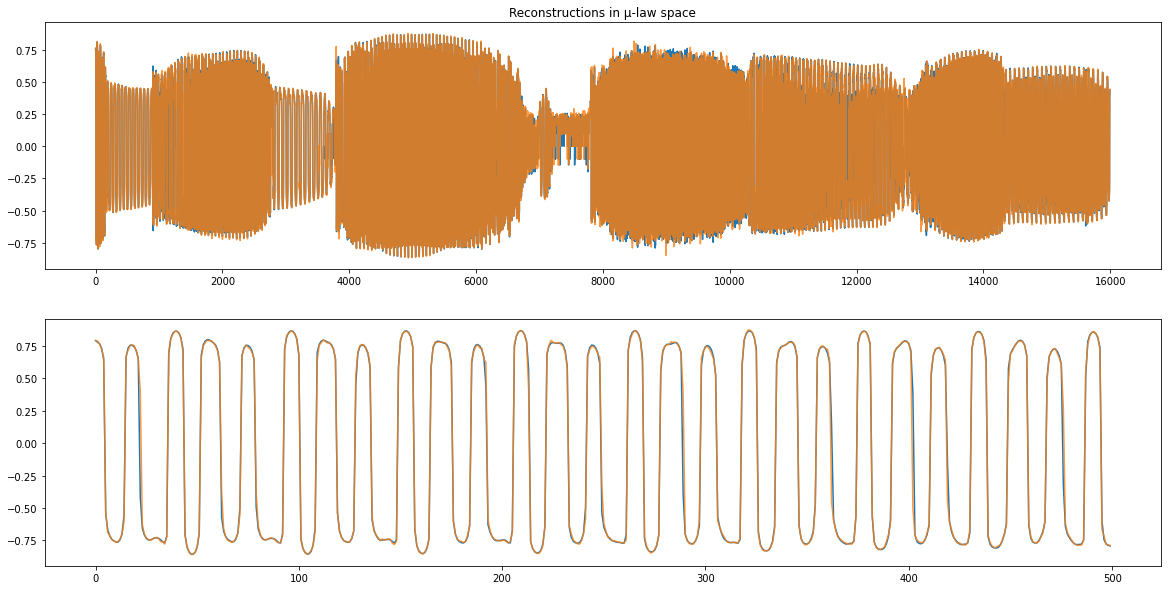

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][21000:21500].cpu())
axes[1].plot(output.reconstructions[0][21000:21500].cpu(), alpha=0.8)

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_mu_law.pdf")

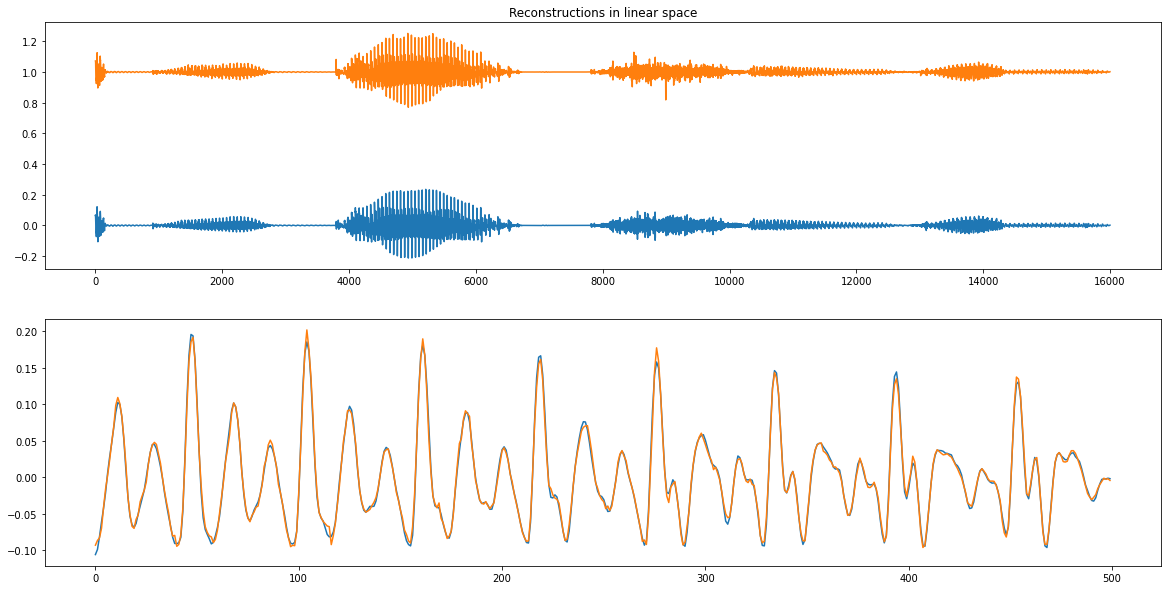

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(output.reconstructions[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(output.reconstructions[0][21500:22000].cpu()))

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear.pdf")

In [ ]:
mode_component = output.reconstructions_parameters[0].softmax(-1).argmax(-1).unsqueeze(-1)
mode = torch.gather(output.reconstructions_parameters[1], index=mode_component, dim=-1).squeeze()
output.reconstructions_parameters[1][0].shape, mode_component.shape, mode.shape

(torch.Size([79872, 1, 10]),
 torch.Size([4, 79872, 1, 1]),
 torch.Size([4, 79872]))

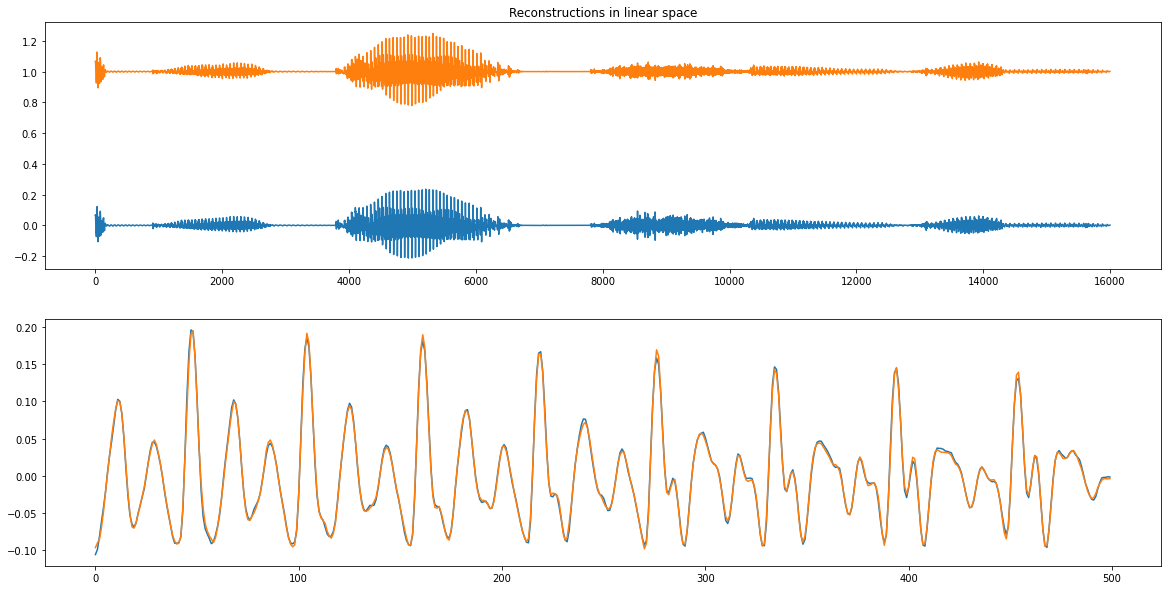

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(mode[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(mode[0][21500:22000].cpu()))

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_from_mode.pdf")

In [ ]:
(mode - x).pow(2).mean(), (output.reconstructions.squeeze() - x).pow(2).mean()

(tensor(0.0567, device='cuda:6'), tensor(0.0672, device='cuda:6'))

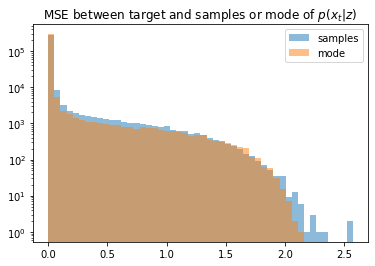

In [ ]:
v, bins, _ = plt.hist((output.reconstructions.squeeze() - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=50, label="samples")
v, bins, _ = plt.hist((mode - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=bins, label="mode")
plt.yscale("log")
plt.title("MSE between target and samples or mode of $p(x_t|z)$")
plt.legend()
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_mse_samples_mode.pdf")

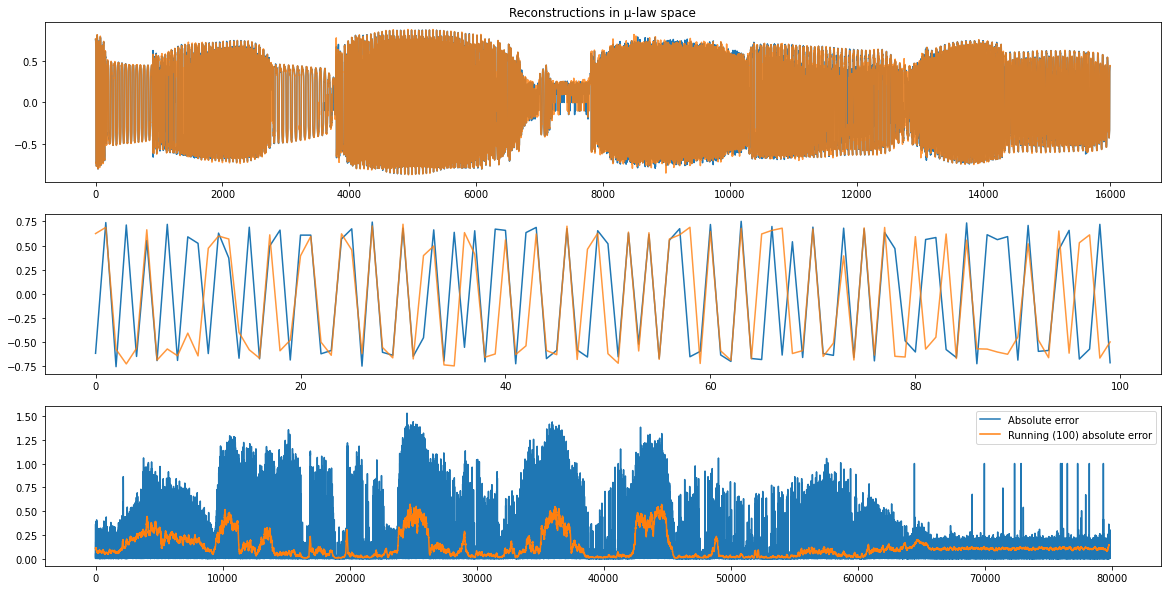

In [ ]:
# Where is the MSE high?

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][25000:25100].cpu())
axes[1].plot(output.reconstructions[0][25000:25100].cpu(), alpha=0.8)


abs_err = (x[0][:].cpu() - output.reconstructions[0][:].cpu().squeeze()).abs()
axes[2].plot(abs_err, label="Absolute error")
axes[2].plot(np.convolve(abs_err, np.ones(100)/100, mode='valid'), label="Running (100) absolute error")

plt.legend()
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_abs_err_over_time.pdf")

In [ ]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=512,
    win_length=320,
    hop_length=160,
    power=2.0,
    normalized=False,
    onesided=True,
)

todb = torchaudio.transforms.AmplitudeToDB()

spec_audio = todb(spectrogram(audio[0]))
spec_recon = todb(spectrogram(output.reconstructions[0].squeeze().cpu()[:audio[0].shape[0]]))

err_freq = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(1)
err_time = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(0)

spec_recon.shape

torch.Size([257, 397])

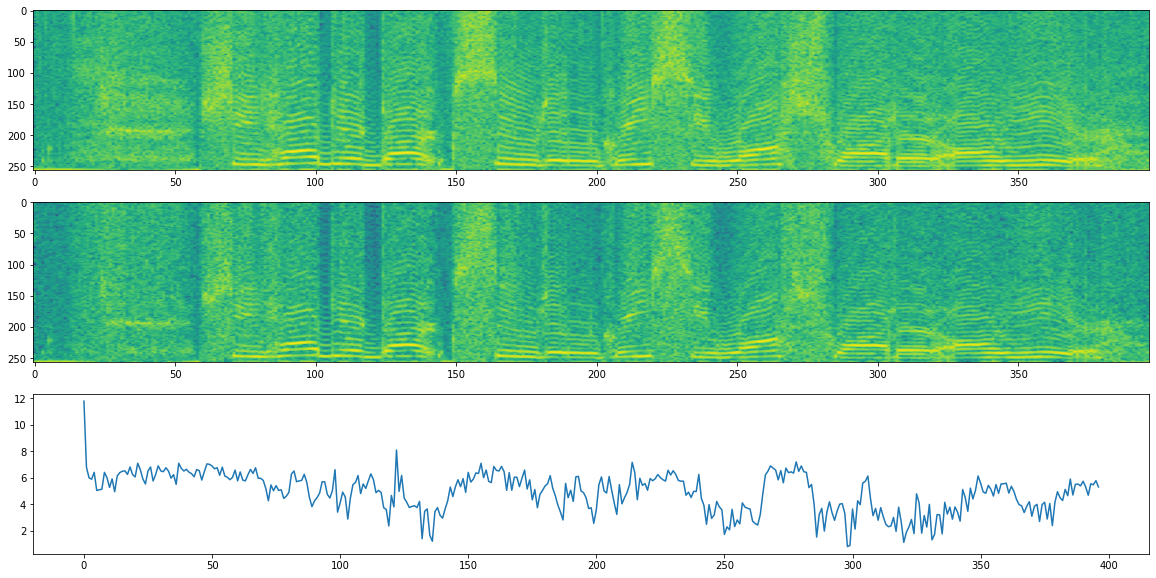

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].imshow(spec_audio.flip(0), aspect="auto")
axes[1].imshow(spec_recon.flip(0), aspect="auto")
axes[2].plot(err_time)

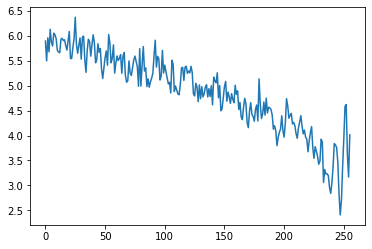

In [ ]:
plt.plot(err_freq[1:])

#### Examine multimodality in the output distribution

In [28]:
mode_idx = output.reconstructions_parameters[0].softmax(-1).argmax(-1, keepdim=True)
mode_weight = torch.gather(output.reconstructions_parameters[0].softmax(-1), index=mode_idx, dim=-1).squeeze()

In [29]:
max_val, va = output.reconstructions_parameters[0].softmax(-1).max(-1, keepdim=True)
not_max_idx = output.reconstructions_parameters[0].softmax(-1) < max_val
not_mode_weigts = output.reconstructions_parameters[0].softmax(-1)[not_max_idx]

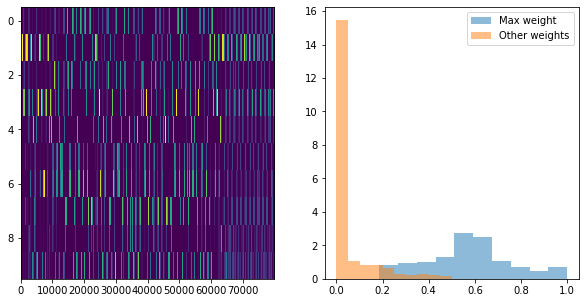

In [30]:
# Which mixture components are used? Does it change over time?
if model.num_mix > 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(output.reconstructions_parameters[0][0].squeeze().cpu().softmax(-1).T, aspect="auto", interpolation="none")
    axes[1].hist(mode_weight[0].cpu().numpy(), alpha=0.5, density=True, label="Max weight")
    axes[1].hist(not_mode_weigts.cpu().numpy(), alpha=0.5, density=True, label="Other weights")

    plt.legend()

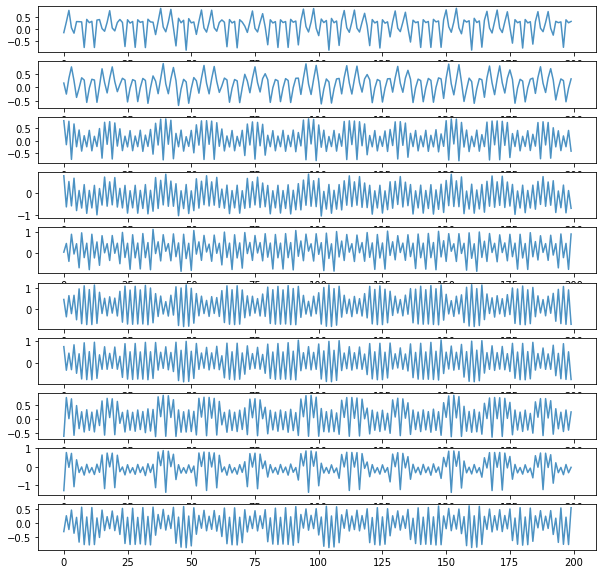

In [31]:
if model.num_mix > 1:
    fig, axes = plt.subplots(10, 1, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.plot(output.reconstructions_parameters[1][0][21000:21200, 0, i].cpu(), alpha=0.8)

In [32]:
output.reconstructions_parameters[1].shape

torch.Size([4, 79872, 1, 10])

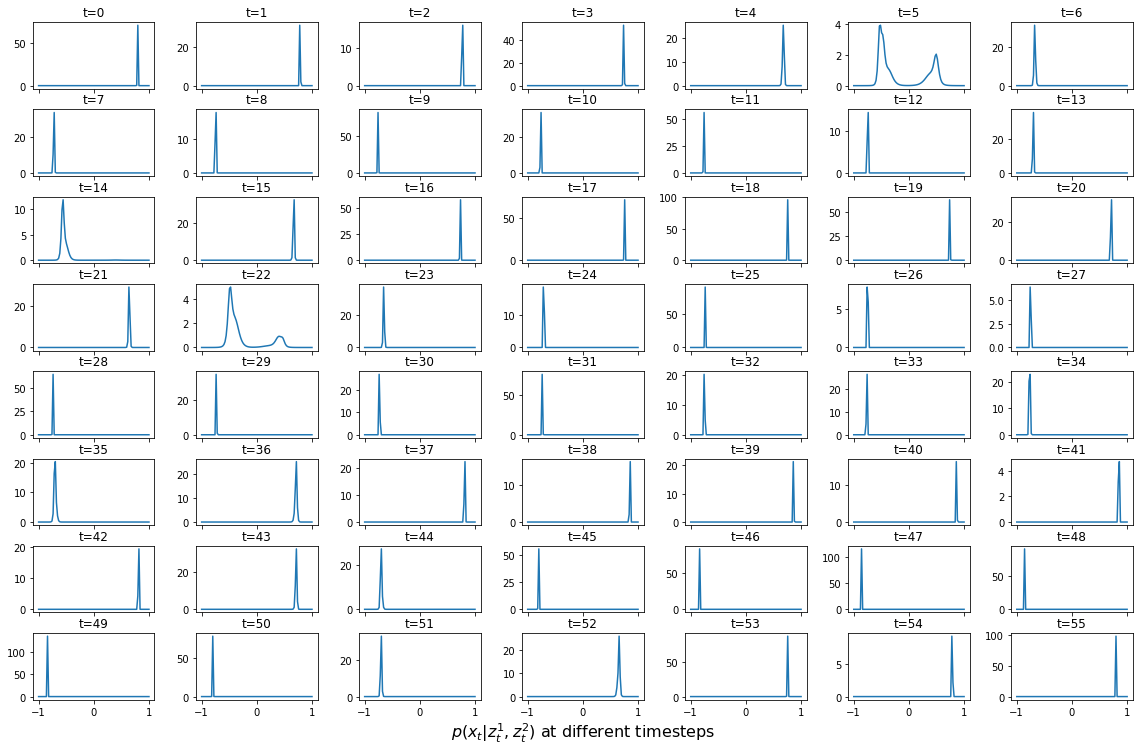

In [ ]:
T = 21000

h, w = 8, 7
n = h * w

fig, axes = plt.subplots(h, w, figsize=(16, 10), sharex=True)
fig.tight_layout()
axes = [a for ax in axes for a in ax]
axes[-w//2].set_xlabel("$p(x_t|z^1_t,z^2_t)$ at different timesteps", fontsize=16)
for t in range(n):
    plot_logistic_mixture(output.reconstructions_parameters[1][0][T+t, 0, :], output.reconstructions_parameters[2][0][T+t, 0, :], output.reconstructions_parameters[0][0][T+t, 0, :], ax=axes[t])
    axes[t].set_title(f"t={t}")

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_p_x_distributions_over_time.pdf")

In [33]:
def logistic_pdf(x, mean, log_scale):
    """
    x (*1)
    means (*1, *2)
    log_scales (*1, *2)
    unnorm_weights (*1, *2)
    """
    scale = log_scale.exp()
    num = torch.exp(-(x-mean) / scale)
    den = scale * (1 + num) ** 2
    pdf = num / den
    pdf = torch.nan_to_num(pdf, nan=0.0, posinf=None, neginf=None)
    return pdf

In [34]:
def logistic_mixture_pdf(x, means, log_scales, unnorm_weights):
    """
    x (B, T)
    means (B, T, M)
    log_scales (B, T, M)
    unnorm_weights (B, T, M)
    """
    pdfs = logistic_pdf(x, means, log_scales)
    weights = unnorm_weights.softmax(-1)
    weighted_pdfs = (pdfs * weights).sum(-1)
    return weighted_pdfs

In [106]:
unnorm_weights = output.reconstructions_parameters[0].reshape(-1, 10).cpu()
means = output.reconstructions_parameters[1].reshape(-1, 10).cpu()
log_scales = output.reconstructions_parameters[2].reshape(-1, 10).cpu()

In [107]:
x = torch.linspace(-1, 1, 500).view(500, 1, 1)
pdf = logistic_pdf(x, means, log_scales)

(-1.0, 1.0)

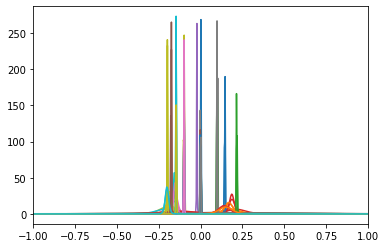

In [108]:
for i in range(10):
    plt.plot(x.cpu().numpy()[:, 0], pdf[:, i].cpu().numpy())
plt.xlim([-1, 1])

In [109]:
scale = log_scales.exp()
num = torch.exp(-(x-means) / scale)
den = scale * (1 + torch.exp(-(x-means) / scale)) ** 2

0.988042

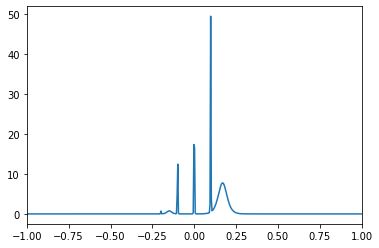

In [110]:
pdf = logistic_mixture_pdf(x, means.cpu(), log_scales.cpu(), unnorm_weights.cpu())
plt.plot(x.cpu().numpy()[:, 0], pdf[:, 3].cpu().numpy())
plt.xlim([-1, 1])
np.trapz(pdf[:, 3], dx=2/500)

In [111]:
import scipy.signal

100%|██████████| 319488/319488 [00:23<00:00, 13607.54it/s]


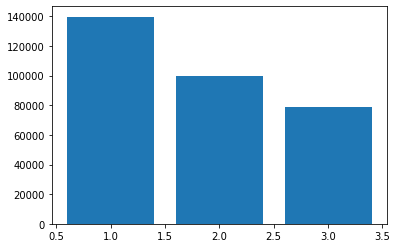

In [173]:
# Distribution of number of peaks per timestep excluding center points from -0.125 to 0.125

time_steps = pdf.shape[1]
# time_steps = 20000

idx = ((x.flatten() > 0.125) + (x.flatten() < -0.125)).numpy()
pdf_numpy = pdf.numpy()
pdf_numpy = pdf_numpy[idx, :]

peaks = []
for t in tqdm.tqdm(range(time_steps)):
    peak, attr = scipy.signal.find_peaks(pdf_numpy[:, t], height=0.1, threshold=None, distance=10, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
    peaks.append(peak)
    
num_peaks = [len(p) for p in peaks]

n, bins = np.histogram(num_peaks, bins=np.array(range(1, max(num_peaks))) - 1/2)
plt.bar(np.array(range(1, max(num_peaks)-1)), n)
plt.savefig(f"./figures/cwvae_evaluation/{run_id}_distribution_of_number_of_peaks_in_output_ignoring_center.pdf")

100%|██████████| 319488/319488 [00:23<00:00, 13528.62it/s]


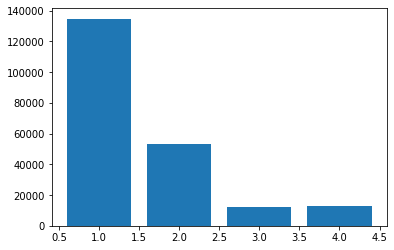

In [175]:
# Distribution of number of peaks per timestep

time_steps = pdf.shape[1]
# time_steps = 20000
pdf_numpy = pdf.numpy()
peaks = []
for t in tqdm.tqdm(range(time_steps)):
    peak, attr = scipy.signal.find_peaks(pdf_numpy[:, t], height=0.1, threshold=None, distance=10, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
    peaks.append(peak)

num_peaks = [len(p) for p in peaks]

n, bins = np.histogram(num_peaks, bins=np.array(range(1, max(num_peaks))) - 1/2)
plt.bar(np.array(range(1, max(num_peaks)-1)), n)
plt.savefig(f"./figures/cwvae_evaluation/{run_id}_distribution_of_number_of_peaks_in_output.pdf")

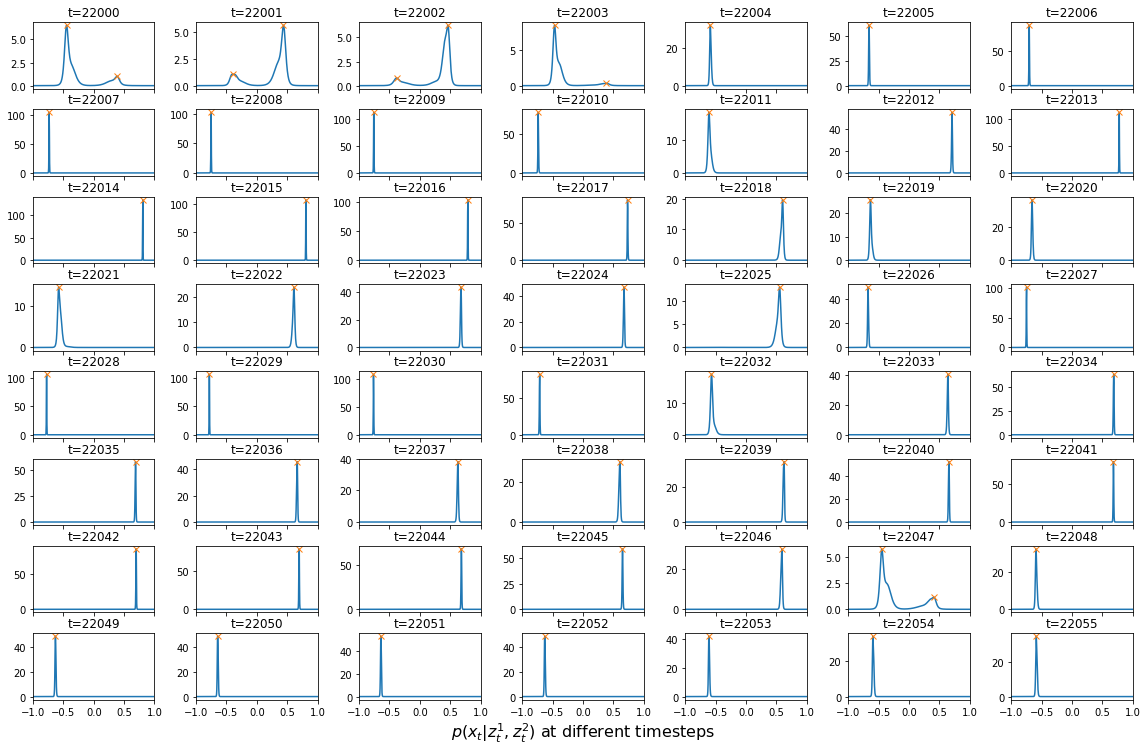

In [177]:
T = 22000

x_plot = x.cpu().numpy()[:, 0, 0]
pdf_plot = pdf.cpu().numpy()

h, w = 8, 7
# h, w = 3, 3
n = h * w

fig, axes = plt.subplots(h, w, figsize=(16, 10), sharex=True)
fig.tight_layout()
axes = [a for ax in axes for a in ax]
axes[-w//2].set_xlabel("$p(x_t|z^1_t,z^2_t)$ at different timesteps", fontsize=16)
for t in range(n):
    axes[t].plot(x_plot, pdf_plot[:, T+t], label="Density")
    axes[t].plot(x_plot[peaks[T+t]], pdf_plot[peaks[T+t], T+t], "x", label="Mode")
    axes[t].set_title(f"t={T+t}")
    axes[t].set_xlim([-1, 1])

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_p_x_distributions_over_time_with_peaks.pdf")

Reconstruction accuracy is generally quite good.

One can note the following things:
- Occasionally, the sampled reconstruction for a single timestep is an outlier. This happens because a poor component is sampled from the mixture of logistics. The problem disappears when decoding from the mode.
- The mixture weights are not generally one hot. The maximum weight has an empirical distribution with a peak at around 0.6. This leaves quite some mass to be distributed to different (to some degree) components.

In [ ]:
data = [valid_dataset[i] for i in range(4)]
audio = [a for i, ((a, p, w, s), metadata) in enumerate(data)]
x, x_sl = audio_batcher(audio)
x = x.to(device)

torch.manual_seed(6)
loss, metrics, output = model(x, x_sl)
data[0][-1]

In [ ]:
audio[0].shape, x.shape, output.reconstructions.shape, output.latents[0].shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][21000:21500].cpu())
axes[1].plot(output.reconstructions[0][21000:21500].cpu(), alpha=0.8)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(output.reconstructions[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(output.reconstructions[0][21500:22000].cpu()))

In [ ]:
mode_component = output.reconstructions_parameters[0].softmax(-1).argmax(-1).unsqueeze(-1)
mode = torch.gather(output.reconstructions_parameters[1], index=mode_component, dim=-1).squeeze()
output.reconstructions_parameters[1][0].shape, mode_component.shape, mode.shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(mode[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(mode[0][21500:22000].cpu()))

In [ ]:
(mode - x).pow(2).mean(), (output.reconstructions.squeeze() - x).pow(2).mean()

In [ ]:
v, bins, _ = plt.hist((output.reconstructions.squeeze() - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=50, label="samples")
v, bins, _ = plt.hist((mode - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=bins, label="mode")
plt.yscale("log")
plt.title("MSE between target and samples from or mode of $p(x_t|z)$")
plt.legend()

In [ ]:
# Where is the MSE high?

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][25000:25100].cpu())
axes[1].plot(output.reconstructions[0][25000:25100].cpu(), alpha=0.8)


abs_err = (x[0][:].cpu() - output.reconstructions[0][:].cpu().squeeze()).abs()
axes[2].plot(abs_err)
axes[2].plot(np.convolve(abs_err, np.ones(100)/100, mode='valid'), label="Running absolute error")

plt.legend()

In [ ]:
import torchaudio

In [ ]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=512,
    win_length=320,
    hop_length=160,
    power=2.0,
    normalized=False,
    onesided=True,
)

todb = torchaudio.transforms.AmplitudeToDB()

spec_audio = todb(spectrogram(audio[0]))
spec_recon = todb(spectrogram(output.reconstructions[0].squeeze().cpu()[:audio[0].shape[0]]))

err_freq = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(1)
err_time = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(0)

spec_recon.shape

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].imshow(spec_audio.flip(0), aspect="auto")
axes[1].imshow(spec_recon.flip(0), aspect="auto")
axes[2].plot(err_time)

In [ ]:
plt.plot(err_freq[1:])

In [ ]:
mode_idx = output.reconstructions_parameters[0].softmax(-1).argmax(-1, keepdim=True)
mode_weight = torch.gather(output.reconstructions_parameters[0].softmax(-1), index=mode_idx, dim=-1).squeeze()

In [ ]:
max_val, va = output.reconstructions_parameters[0].softmax(-1).max(-1, keepdim=True)
not_max_idx = output.reconstructions_parameters[0].softmax(-1) < max_val
not_mode_weigts = output.reconstructions_parameters[0].softmax(-1)[not_max_idx]

In [ ]:
# Which mixture components are used? Does it change over time?
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(output.reconstructions_parameters[0][0].squeeze().cpu().softmax(-1).T, aspect="auto", interpolation="none")
axes[1].hist(mode_weight[0].cpu().numpy(), alpha=0.5, density=True, label="Max weight")
axes[1].hist(not_mode_weigts.cpu().numpy(), alpha=0.5, density=True, label="Other weights");

plt.legend()

In [ ]:
T = 21000

h, w = 8, 7
n = h * w

fig, axes = plt.subplots(h, w, figsize=(16, 10), sharex=True)
fig.tight_layout()
axes = [a for ax in axes for a in ax]
axes[-w//2].set_xlabel("$p(x_t|z^1_t,z^2_t)$ at different timesteps", fontsize=16)
for t in range(n):
    plot_logistic_mixture(output.reconstructions_parameters[1][0][T+t, 0, :], output.reconstructions_parameters[2][0][T+t, 0, :], output.reconstructions_parameters[0][0][T+t, 0, :], ax=axes[t])
    axes[t].set_title(f"t={t}")

In [ ]:
fig, axes = plt.subplots(10, 1, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(output.reconstructions_parameters[1][0][21000:21200, 0, i].cpu(), alpha=0.8)

# Reconstructions

### Notes
Reconstruction accuracy is generally quite good.

One can note the following things:
- Occasionally, the sampled reconstruction for a single timestep is an outlier. This happens because a poor component is sampled from the mixture of logistics. The problem disappears when decoding from the mode.
- The mixture weights are not generally one hot. The maximum weight has an empirical distribution with a peak at around 0.6. This leaves quite some mass to be distributed to different (to some degree) components.

In [ ]:
data = [valid_dataset[i] for i in range(4)]
audio = [a for i, ((a, p, w, s), metadata) in enumerate(data)]
x, x_sl = audio_batcher(audio)
x = x.to(device)

torch.manual_seed(6)
loss, metrics, output = model(x, x_sl)
data[0][-1]

In [ ]:
audio[0].shape, x.shape, output.reconstructions.shape, output.latents[0].shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][21000:21500].cpu())
axes[1].plot(output.reconstructions[0][21000:21500].cpu(), alpha=0.8)

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_mu_law.pdf")

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(output.reconstructions[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(output.reconstructions[0][21500:22000].cpu()))

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear.pdf")

In [ ]:
mode_component = output.reconstructions_parameters[0].softmax(-1).argmax(-1).unsqueeze(-1)
mode = torch.gather(output.reconstructions_parameters[1], index=mode_component, dim=-1).squeeze()
output.reconstructions_parameters[1][0].shape, mode_component.shape, mode.shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(mode[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(mode[0][21500:22000].cpu()))

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_from_mode.pdf")

In [ ]:
(mode - x).pow(2).mean(), (output.reconstructions.squeeze() - x).pow(2).mean()

In [ ]:
v, bins, _ = plt.hist((output.reconstructions.squeeze() - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=50, label="samples")
v, bins, _ = plt.hist((mode - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=bins, label="mode")
plt.yscale("log")
plt.title("MSE between target and samples or mode of $p(x_t|z)$")
plt.legend()
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_mse_samples_mode.pdf")

In [ ]:
# Where is the MSE high?

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][25000:25100].cpu())
axes[1].plot(output.reconstructions[0][25000:25100].cpu(), alpha=0.8)


abs_err = (x[0][:].cpu() - output.reconstructions[0][:].cpu().squeeze()).abs()
axes[2].plot(abs_err, label="Absolute error")
axes[2].plot(np.convolve(abs_err, np.ones(100)/100, mode='valid'), label="Running (100) absolute error")

plt.legend()
fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_linear_abs_err_over_time.pdf")

In [ ]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=512,
    win_length=320,
    hop_length=160,
    power=2.0,
    normalized=False,
    onesided=True,
)

todb = torchaudio.transforms.AmplitudeToDB()

spec_audio = todb(spectrogram(audio[0]))
spec_recon = todb(spectrogram(output.reconstructions[0].squeeze().cpu()[:audio[0].shape[0]]))

err_freq = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(1)
err_time = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(0)

spec_recon.shape

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].imshow(spec_audio.flip(0), aspect="auto")
axes[1].imshow(spec_recon.flip(0), aspect="auto")
axes[2].plot(err_time)

In [ ]:
plt.plot(err_freq[1:])

In [ ]:
mode_idx = output.reconstructions_parameters[0].softmax(-1).argmax(-1, keepdim=True)
mode_weight = torch.gather(output.reconstructions_parameters[0].softmax(-1), index=mode_idx, dim=-1).squeeze()

In [ ]:
max_val, va = output.reconstructions_parameters[0].softmax(-1).max(-1, keepdim=True)
not_max_idx = output.reconstructions_parameters[0].softmax(-1) < max_val
not_mode_weigts = output.reconstructions_parameters[0].softmax(-1)[not_max_idx]

In [ ]:
# Which mixture components are used? Does it change over time?
if model.num_mix > 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(output.reconstructions_parameters[0][0].squeeze().cpu().softmax(-1).T, aspect="auto", interpolation="none")
    axes[1].hist(mode_weight[0].cpu().numpy(), alpha=0.5, density=True, label="Max weight")
    axes[1].hist(not_mode_weigts.cpu().numpy(), alpha=0.5, density=True, label="Other weights")

    plt.legend()

In [ ]:
if model.num_mix > 1:
    fig, axes = plt.subplots(10, 1, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.plot(output.reconstructions_parameters[1][0][21000:21200, 0, i].cpu(), alpha=0.8)

In [ ]:
T = 21000

h, w = 8, 7
n = h * w

fig, axes = plt.subplots(h, w, figsize=(16, 10), sharex=True)
fig.tight_layout()
axes = [a for ax in axes for a in ax]
axes[-w//2].set_xlabel("$p(x_t|z^1_t,z^2_t)$ at different timesteps", fontsize=16)
for t in range(n):
    plot_logistic_mixture(output.reconstructions_parameters[1][0][T+t, 0, :], output.reconstructions_parameters[2][0][T+t, 0, :], output.reconstructions_parameters[0][0][T+t, 0, :], ax=axes[t])
    axes[t].set_title(f"t={t}")

fig.savefig(f"./figures/cwvae_evaluation/{run_id}_reconstruction_p_x_distributions_over_time.pdf")

Reconstruction accuracy is generally quite good.

One can note the following things:
- Occasionally, the sampled reconstruction for a single timestep is an outlier. This happens because a poor component is sampled from the mixture of logistics. The problem disappears when decoding from the mode.
- The mixture weights are not generally one hot. The maximum weight has an empirical distribution with a peak at around 0.6. This leaves quite some mass to be distributed to different (to some degree) components.

In [ ]:
data = [valid_dataset[i] for i in range(4)]
audio = [a for i, ((a, p, w, s), metadata) in enumerate(data)]
x, x_sl = audio_batcher(audio)
x = x.to(device)

torch.manual_seed(6)
loss, metrics, output = model(x, x_sl)
data[0][-1]

In [ ]:
audio[0].shape, x.shape, output.reconstructions.shape, output.latents[0].shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][21000:21500].cpu())
axes[1].plot(output.reconstructions[0][21000:21500].cpu(), alpha=0.8)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(output.reconstructions[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(output.reconstructions[0][21500:22000].cpu()))

In [ ]:
mode_component = output.reconstructions_parameters[0].softmax(-1).argmax(-1).unsqueeze(-1)
mode = torch.gather(output.reconstructions_parameters[1], index=mode_component, dim=-1).squeeze()
output.reconstructions_parameters[1][0].shape, mode_component.shape, mode.shape

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in linear space")

axes[0].plot(transform_dec(audio[0][16000:32000].cpu()))
axes[0].plot(transform_dec(mode[0][16000:32000].cpu()) + 1)

axes[1].plot(transform_dec(audio[0][21500:22000].cpu()))
axes[1].plot(transform_dec(mode[0][21500:22000].cpu()))

In [ ]:
(mode - x).pow(2).mean(), (output.reconstructions.squeeze() - x).pow(2).mean()

In [ ]:
v, bins, _ = plt.hist((output.reconstructions.squeeze() - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=50, label="samples")
v, bins, _ = plt.hist((mode - x).pow(2).flatten().cpu().numpy(), alpha=0.5, bins=bins, label="mode")
plt.yscale("log")
plt.title("MSE between target and samples from or mode of $p(x_t|z)$")
plt.legend()

In [ ]:
# Where is the MSE high?

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].set_title("Reconstructions in µ-law space")

axes[0].plot(x[0][16000:32000].cpu())
axes[0].plot(output.reconstructions[0][16000:32000].cpu(), alpha=0.8)

axes[1].plot(x[0][25000:25100].cpu())
axes[1].plot(output.reconstructions[0][25000:25100].cpu(), alpha=0.8)


abs_err = (x[0][:].cpu() - output.reconstructions[0][:].cpu().squeeze()).abs()
axes[2].plot(abs_err)
axes[2].plot(np.convolve(abs_err, np.ones(100)/100, mode='valid'), label="Running absolute error")

plt.legend()

In [ ]:
import torchaudio

In [ ]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=512,
    win_length=320,
    hop_length=160,
    power=2.0,
    normalized=False,
    onesided=True,
)

todb = torchaudio.transforms.AmplitudeToDB()

spec_audio = todb(spectrogram(audio[0]))
spec_recon = todb(spectrogram(output.reconstructions[0].squeeze().cpu()[:audio[0].shape[0]]))

err_freq = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(1)
err_time = (spec_audio.flip(0) - spec_recon.flip(0)).abs().mean(0)

spec_recon.shape

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].imshow(spec_audio.flip(0), aspect="auto")
axes[1].imshow(spec_recon.flip(0), aspect="auto")
axes[2].plot(err_time)

In [ ]:
plt.plot(err_freq[1:])

In [ ]:
mode_idx = output.reconstructions_parameters[0].softmax(-1).argmax(-1, keepdim=True)
mode_weight = torch.gather(output.reconstructions_parameters[0].softmax(-1), index=mode_idx, dim=-1).squeeze()

In [ ]:
max_val, va = output.reconstructions_parameters[0].softmax(-1).max(-1, keepdim=True)
not_max_idx = output.reconstructions_parameters[0].softmax(-1) < max_val
not_mode_weigts = output.reconstructions_parameters[0].softmax(-1)[not_max_idx]

In [ ]:
# Which mixture components are used? Does it change over time?
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(output.reconstructions_parameters[0][0].squeeze().cpu().softmax(-1).T, aspect="auto", interpolation="none")
axes[1].hist(mode_weight[0].cpu().numpy(), alpha=0.5, density=True, label="Max weight")
axes[1].hist(not_mode_weigts.cpu().numpy(), alpha=0.5, density=True, label="Other weights");

plt.legend()

In [ ]:
T = 21000

h, w = 8, 7
n = h * w

fig, axes = plt.subplots(h, w, figsize=(16, 10), sharex=True)
fig.tight_layout()
axes = [a for ax in axes for a in ax]
axes[-w//2].set_xlabel("$p(x_t|z^1_t,z^2_t)$ at different timesteps", fontsize=16)
for t in range(n):
    plot_logistic_mixture(output.reconstructions_parameters[1][0][T+t, 0, :], output.reconstructions_parameters[2][0][T+t, 0, :], output.reconstructions_parameters[0][0][T+t, 0, :], ax=axes[t])
    axes[t].set_title(f"t={t}")

In [ ]:
fig, axes = plt.subplots(10, 1, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(output.reconstructions_parameters[1][0][21000:21200, 0, i].cpu(), alpha=0.8)